In [1]:
!pip install accelerate #after this restart the session
!pip install -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.4 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5

In [2]:
!pip install openpyxl
!pip install seaborn

In [3]:
!huggingface-cli login --token --token_KEY

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
The token `project-RAG` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `project-RAG`


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import time
import transformers
import torch


In [5]:
from textblob import TextBlob
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Data Loading and Cleaning

In [6]:
# --- Load Data ---
data_all = pd.read_excel("/kaggle/input/dataset/pitchfork_reviews.xlsx", sheet_name="Result 1")


In [7]:
data_all.head()

,artist,album,score,year,reviewer,genre,label,review_date,summary,review,best_new
0,Green-House,A Host for All Kinds of Life,7.6,2023,Hattie Lindert,Electronic / Experimental,Leaving,"October 23, 2023",The Los Angeles ambient musician continues to ...,For proof that we all must ultimately coexist ...,Not Available
1,Tkay Maidza,Sweet Justice,7.6,2023,Dylan Green,Pop/R&B,4AD,"November 3, 2023",The Australian musician chooses herself over t...,Tkay Maidza’s three-partLast Year Was WeirdEP ...,Not Available
2,A Giant Dog,Bite,6.4,2023,Linnie Greene,Rock,Merge,"August 28, 2023","On its first album in six years, the Austin gr...","A Giant Dog’sBite, the Austin, Texas, group’s ...",Not Available
3,Margaret Glaspy,Echo the Diamond,7.7,2023,Marc Hogan,Rock,ATO,"August 23, 2023","On her third album, the Brooklyn musician scra...",Margaret Glaspyhad only a couple of EPs to her...,Not Available
4,Maria BC,Spike Field,7.8,2023,Hannah Jocelyn,Rock / Experimental,Sacred Bones,"October 26, 2023","On their spectral new album, the Oakland music...","Since the 1980s, teams of engineers, anthropol...",Not Available


In [8]:
data_all.describe()

,artist,album,score,year,reviewer,genre,label,review_date,summary,review,best_new
count,25707,25707,25708,25708,25708,25708,25708,25708,25703,25107,25708
unique,11144,24177,102,65,635,151,7457,6232,24805,25085,3
top,Various Artists,Not Available,7.5,2007,Not Available,Rock,Not Available,Not Available,Not Available,"It was probably overstated, but a few years ag...",Not Available
freq,791,598,1321,1236,1860,8638,600,2945,850,2,24389


In [9]:
# Remove HTML: If reviews were scraped, they likely contain HTML tags. Use a library like BeautifulSoup
from bs4 import BeautifulSoup
def strip_html(text):
    if isinstance(text, str):
        soup = BeautifulSoup(text, "html.parser")
        return soup.get_text()
    return text
# Normalize Whitespace: Remove extra spaces, newlines, tabs.
def normalize_whitespace(text):
    if isinstance(text, str):
        return " ".join(text.split())
    return text

In [10]:
import numpy as np

# Replace "Not Available" with NaN
data_all.replace("Not Available", np.nan, inplace=True)
len(data_all)


25708

In [11]:
if 'best_new' in data_all.columns:
    # Convert potential string "True"/"False" or boolean True/False, and NaNs to a consistent boolean type.
    # NaNs (which came from "Not Available") will be treated as False.
    # If 'best_new' is already boolean and just has NaNs, fillna(False) is enough.
    # If it might contain strings 'True'/'False', a map can be more robust.
    # For simplicity, assuming it's either boolean, or NaN which means False for "Best New Music"
    data_all['best_new'] = data_all['best_new'].fillna(False).astype(bool)
    print("Processed 'best_new' column. NaNs filled with False, type converted to boolean.")
else:
    print("'best_new' column not found. Cannot process it.")

Processed 'best_new' column. NaNs filled with False, type converted to boolean.


In [12]:
print(data_all['genre'].value_counts(dropna=False))


genre
Rock                                    8638
Electronic                              2973
NaN                                     2945
Rap                                     2366
Pop/R&B                                 1695
                                        ... 
Global / Rap                               1
Rock / Experimental / Jazz                 1
Electronic / Global / Rap                  1
Global / Pop/R&B / Electronic / Rock       1
Experimental / Folk/Country / Jazz         1
Name: count, Length: 151, dtype: int64


In [13]:
len(data_all)

25708

In [14]:
essential_cols = ['artist', 'album', 'review', 'score'] # Add 'summary' if it's a primary text source
data_all.dropna(subset=essential_cols, inplace=True)
data_all.drop_duplicates(subset=['artist', 'album'], inplace=True, keep='first')

In [15]:
data_all.dropna(inplace=True)


In [16]:
data_all['year'] = pd.to_numeric(data_all['year'], errors='coerce')  # Convert to numbers, set invalid to NaN
data_all = data_all[(data_all['year'] >= 2001) & (data_all['year'] <= 2023)]
data_all

,artist,album,score,year,reviewer,genre,label,review_date,summary,review,best_new
0,Green-House,A Host for All Kinds of Life,7.6,2023,Hattie Lindert,Electronic / Experimental,Leaving,"October 23, 2023",The Los Angeles ambient musician continues to ...,For proof that we all must ultimately coexist ...,False
1,Tkay Maidza,Sweet Justice,7.6,2023,Dylan Green,Pop/R&B,4AD,"November 3, 2023",The Australian musician chooses herself over t...,Tkay Maidza’s three-partLast Year Was WeirdEP ...,False
2,A Giant Dog,Bite,6.4,2023,Linnie Greene,Rock,Merge,"August 28, 2023","On its first album in six years, the Austin gr...","A Giant Dog’sBite, the Austin, Texas, group’s ...",False
3,Margaret Glaspy,Echo the Diamond,7.7,2023,Marc Hogan,Rock,ATO,"August 23, 2023","On her third album, the Brooklyn musician scra...",Margaret Glaspyhad only a couple of EPs to her...,False
4,Maria BC,Spike Field,7.8,2023,Hannah Jocelyn,Rock / Experimental,Sacred Bones,"October 26, 2023","On their spectral new album, the Oakland music...","Since the 1980s, teams of engineers, anthropol...",False
...,...,...,...,...,...,...,...,...,...,...,...
25672,Saint Etienne,Interlude,7.8,2001,Rich Juzwiak,Electronic / Rock,Sub Pop,"February 20, 2001","I don't have an exact formula, but I figure th...","I don't have an exact formula, but I figure th...",False
25674,John Zorn,Songs from the Hermetic Theatre,8.6,2001,Brent S. Sirota,Experimental / Jazz,Tzadik,"June 26, 2001",Feeling irremediably bourgeois? Complacent? Ti...,Feeling irremediably bourgeois? Complacent? Ti...,False
25683,The Long Winters,The Worst You Can Do Is Harm,7.3,2002,Rob Mitchum,Rock,Barsuk,"March 25, 2002",WASHINGTON-- In a stunning move reflecting yet...,WASHINGTON-- In a stunning move reflecting yet...,False
25687,Mogwai,Rock Action,8.0,2001,Matt LeMay,Rock,Matador,"April 30, 2001",There are a few things in this world I'm prett...,There are a few things in this world I'm prett...,False


In [17]:
len(data_all)

20508

In [18]:
# Fill missing genres
data_all['genre'] = data_all['genre'].fillna("Unknown")

In [19]:
# Drop unnecessary columns
columns_to_drop = ['reviewer', 'label', 'review_date']
existing_columns_to_drop = [col for col in columns_to_drop if col in data_all.columns]
if existing_columns_to_drop:
    data_all.drop(columns=existing_columns_to_drop, inplace=True)


In [20]:

# Verify null counts for the remaining important columns
print("Null counts after cleaning:")
relevant_cols_for_null_check = ['artist', 'album', 'score', 'year', 'genre', 'summary', 'review', 'best_new']
existing_relevant_cols = [col for col in relevant_cols_for_null_check if col in data_all.columns]
if existing_relevant_cols:
    print(data_all[existing_relevant_cols].isnull().sum())
else:
    print("No relevant columns found for null check (this is unexpected).")
print("\n")

Null counts after cleaning:
artist      0
album       0
score       0
year        0
genre       0
summary     0
review      0
best_new    0
dtype: int64




In [21]:
data_all.to_csv('reviews.csv', index=False)
print(f"Cleaned data saved. Shape: {data_all.shape}")

Cleaned data saved. Shape: (20508, 8)


In [22]:
# Load the cleaned data for EDA
data = pd.read_csv('reviews.csv')


# 1. Review Length Distribution

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


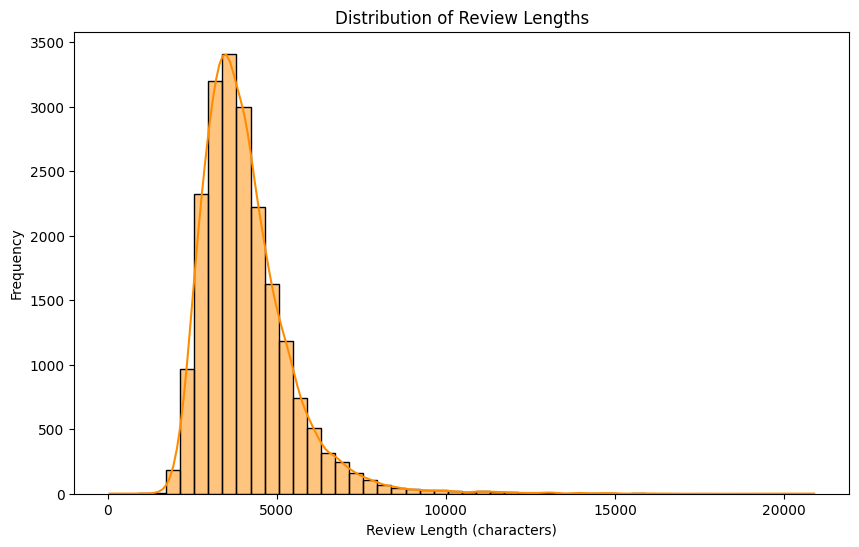

count    20508.000000
mean      4082.430954
std       1338.974157
min         59.000000
25%       3201.000000
50%       3830.500000
75%       4654.000000
max      20890.000000
Name: review_length, dtype: float64


In [23]:
data['review_length'] = data['review'].str.len()
plt.figure(figsize=(10, 6))
sns.histplot(data['review_length'], kde=True, bins=50, color='darkorange')
plt.xlabel('Review Length (characters)')
plt.ylabel('Frequency')
plt.title('Distribution of Review Lengths')
plt.show()
print(data["review_length"].describe())

# 2. Reviews by Year

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


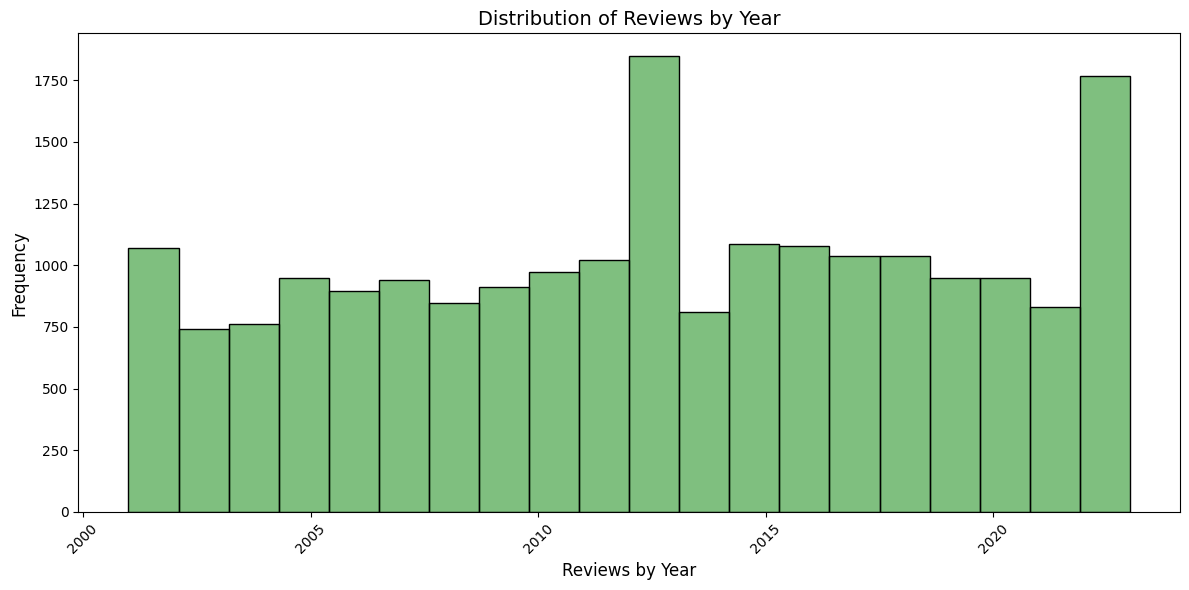

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))  # Adjust figure size for better readability
sns.histplot(data['year'], bins=20, color='green', alpha=0.5)  # Increase bins for better granularity
plt.xlabel('Reviews by Year', fontsize=12)  # Add a clear x-axis label
plt.ylabel('Frequency', fontsize=12)  # Add a clear y-axis label
plt.title('Distribution of Reviews by Year', fontsize=14)  # Add a title

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

# 3. Genre Distribution (Grouped)

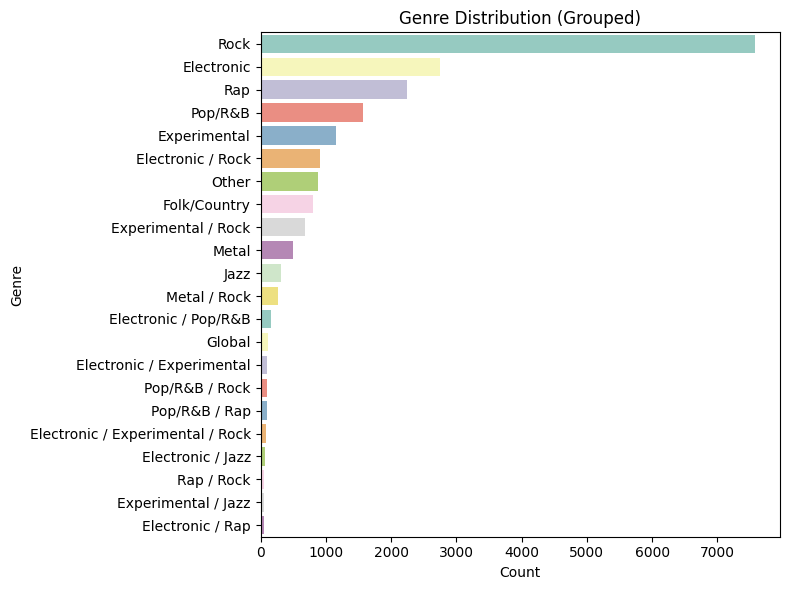

In [25]:
genre_counts = data['genre'].value_counts()
threshold = 50
data['genre'] = data['genre'].apply(lambda x: x if genre_counts[x] > threshold else 'Other')
plt.figure(figsize=(8, 6))
sns.countplot(data=data, y="genre", order=data['genre'].value_counts().index, palette='Set3')
plt.title('Genre Distribution (Grouped)')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

# 4. Number of Tokens

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


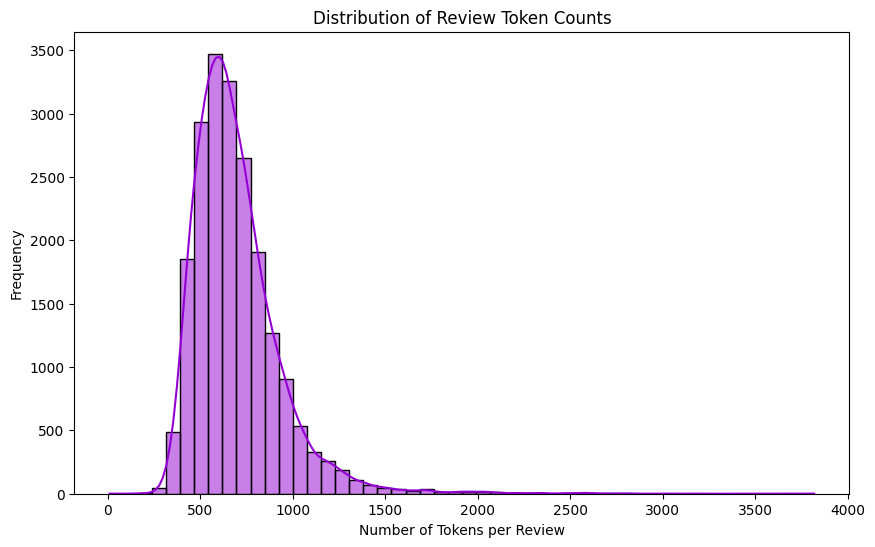

In [26]:
data['num_tokens'] = data['review'].apply(lambda text: len(TextBlob(text).words))
plt.figure(figsize=(10, 6))
sns.histplot(data['num_tokens'], kde=True, bins=50, color='darkviolet')
plt.xlabel('Number of Tokens per Review')
plt.ylabel('Frequency')
plt.title('Distribution of Review Token Counts')
plt.show()


# 5. Sentiment Analysis

In [70]:
data['polarity'] = data['review'].apply(lambda text: TextBlob(text).sentiment.polarity)
data['subjectivity'] = data['review'].apply(lambda text: TextBlob(text).sentiment.subjectivity)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


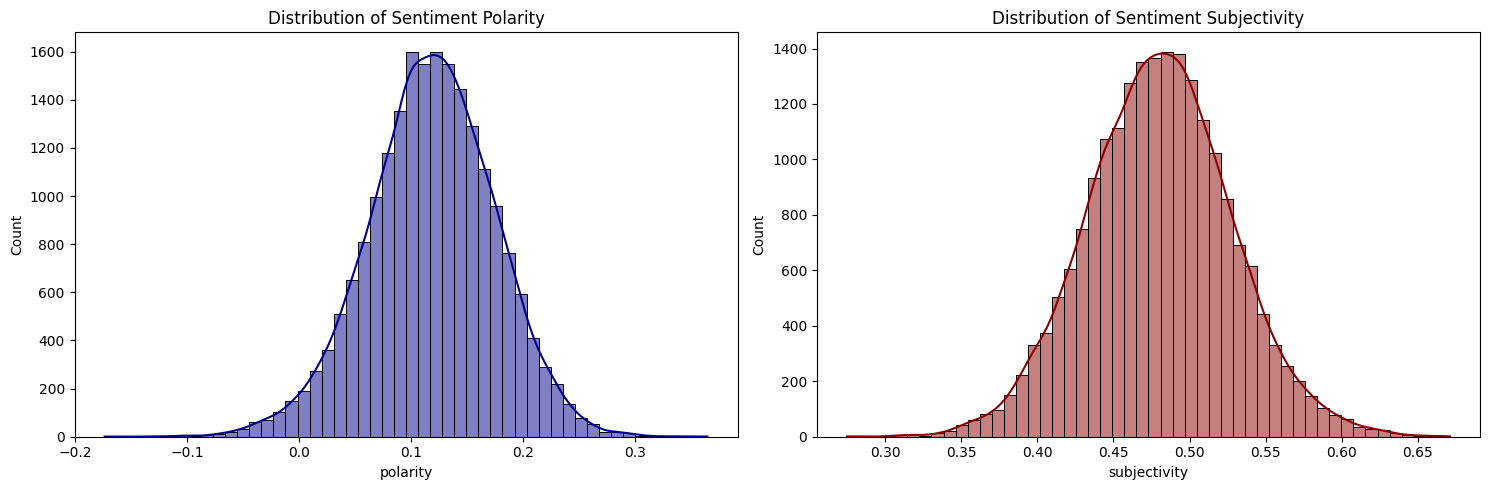

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data['polarity'], kde=True, bins=50, color='darkblue', ax=axes[0])
axes[0].set_title('Distribution of Sentiment Polarity')
sns.histplot(data['subjectivity'], kde=True, bins=50, color='darkred', ax=axes[1])
axes[1].set_title('Distribution of Sentiment Subjectivity')
plt.tight_layout()
plt.show()

In [72]:
print(f"Total entries after EDA filtering: {len(data)}")

Total entries after EDA filtering: 20508


In [37]:
!pip install langchain
!pip install  -U langchain-community
!pip install -q -U faiss-cpu tiktoken sentence-transformers
!pip install tf-keras
!pip install rank_bm25

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [38]:
import pandas as pd
import numpy as np
import torch
import transformers
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain.retrievers import BM25Retriever, EnsembleRetriever # BM25Retriever is in langchain.retrievers
from langchain.chains import ConversationalRetrievalChain
from langchain.prompts import PromptTemplate
from sentence_transformers import CrossEncoder
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, BitsAndBytesConfig
from langchain_text_splitters import RecursiveCharacterTextSplitter # Correct import
from langchain_core.documents import Document
from langchain.llms import HuggingFacePipeline # For LLM wrapper
from langchain.memory import ConversationBufferMemory
from langchain_core.output_parsers import StrOutputParser
from langchain.embeddings import CacheBackedEmbeddings
from langchain.embeddings import CacheBackedEmbeddings, HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.storage import LocalFileStore
from langchain.chains import ConversationalRetrievalChain
from langchain.llms import HuggingFacePipeline
from langchain.document_loaders.csv_loader import CSVLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain import PromptTemplate

In [35]:
# --- Required Imports ---
import pandas as pd
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document

# --- Load Cleaned Data for RAG ---
df = pd.read_csv("reviews.csv")

def create_music_documents_optimized(df):
    """
    Create optimized LangChain documents for music recommendation RAG
    """
    documents = []
    
    for _, row in df.iterrows():
        # Create rich content with structured information
        content_parts = []
        
        # Add structured metadata at the beginning for better context
        header = f"Artist: {row['artist']} | Album: {row['album']} | Genre: {row['genre']}"
        if pd.notna(row['year']) and row['year'] != 0:
            header += f" | Year: {int(row['year'])}"
        if pd.notna(row['score']):
            header += f" | Score: {row['score']}/10"
        if pd.notna(row['best_new']) and row['best_new']:
            header += " | Best New Music"
            
        content_parts.append(header)
        content_parts.append("---")
        content_parts.append(f"Review: {row['review']}")
        
        content_text = "\n".join(content_parts)
        
        # Enhanced metadata for better filtering and retrieval
        metadata = {
            "artist": str(row['artist']).strip(),
            "album": str(row['album']).strip(),
            "score": float(row['score']) if pd.notna(row['score']) else 0.0,
            "year": int(row['year']) if pd.notna(row['year']) else 0,
            "genre": str(row['genre']).strip(),
            "best_new": bool(row['best_new']) if pd.notna(row['best_new']) else False,
            # Additional computed metadata for better retrieval
            "score_category": get_score_category(row['score']),
            "decade": get_decade(row['year']) if pd.notna(row['year']) else "unknown",
            "content_length": len(str(row['review'])),
            "artist_album": f"{row['artist']} - {row['album']}".strip()
        }
        
        documents.append(Document(page_content=content_text, metadata=metadata))
    
    return documents

def get_score_category(score):
    """Categorize scores for better filtering"""
    if pd.isna(score):
        return "unrated"
    elif score >= 8.5:
        return "excellent"
    elif score >= 7.0:
        return "good"
    elif score >= 5.5:
        return "average"
    else:
        return "poor"

def get_decade(year):
    """Get decade for temporal grouping"""
    if pd.isna(year) or year == 0:
        return "unknown"
    return f"{int(year // 10) * 10}s"

def smart_music_chunking(documents, chunk_size=800, chunk_overlap=100):
    """
    Intelligent chunking for music reviews with context preservation
    """
    from langchain.text_splitter import RecursiveCharacterTextSplitter
    
    # Music-specific separators that preserve context
    music_separators = [
        "\n---\n",      # Our custom separator
        "\n\n",         # Paragraph breaks
        "\nTrack",      # Track mentions
        "\nSong",       # Song mentions  
        "\nThe album",  # Album discussions
        "\nMusically", # Musical analysis
        "\nLyrically", # Lyrical analysis
        "\n",          # Line breaks
        ". ",          # Sentence endings
        ", ",          # Phrases
        " "            # Words
    ]
    
    splitter = RecursiveCharacterTextSplitter(
        separators=music_separators,
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len,
        is_separator_regex=False
    )
    
    chunked_docs = []
    
    for doc in documents:
        # Split the document
        chunks = splitter.create_documents([doc.page_content])
        
        for i, chunk in enumerate(chunks):
            # Preserve original metadata and add chunk-specific info
            enhanced_metadata = {
                **doc.metadata,
                "chunk_id": i + 1,
                "total_chunks": len(chunks),
                "chunk_type": "review_segment"
            }
            
            # Ensure each chunk retains key context
            chunk_content = chunk.page_content
            
            # If chunk doesn't contain the header info, add essential context
            if not chunk_content.startswith("Artist:"):
                context = f"[{doc.metadata['artist']} - {doc.metadata['album']}]\n"
                chunk_content = context + chunk_content
                enhanced_metadata["context_added"] = True
            
            chunked_docs.append(Document(
                page_content=chunk_content,
                metadata=enhanced_metadata
            ))
    
    return chunked_docs

def create_multi_level_chunks(documents):
    """
    Create chunks at multiple granularities for comprehensive retrieval
    """
    all_chunks = []
    
    # Level 1: Album-level chunks (larger context)
    album_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1200,
        chunk_overlap=150,
        separators=["\n---\n", "\n\n", "\n", ". ", " "]
    )
    
    album_chunks = album_splitter.split_documents(documents)
    for chunk in album_chunks:
        chunk.metadata["chunk_level"] = "album"
        chunk.metadata["chunk_size"] = "large"
    
    # Level 2: Review-level chunks (medium context) 
    review_splitter = RecursiveCharacterTextSplitter(
        chunk_size=600,
        chunk_overlap=80,
        separators=["\n\n", "\nTrack", "\nSong", "\n", ". ", " "]
    )
    
    review_chunks = review_splitter.split_documents(documents)
    for chunk in review_chunks:
        chunk.metadata["chunk_level"] = "review"
        chunk.metadata["chunk_size"] = "medium"
    
    # Level 3: Sentence-level chunks (precise matching)
    sentence_splitter = RecursiveCharacterTextSplitter(
        chunk_size=300,
        chunk_overlap=30,
        separators=[". ", "\n", ", ", " "]
    )
    
    sentence_chunks = sentence_splitter.split_documents(documents)
    for chunk in sentence_chunks:
        chunk.metadata["chunk_level"] = "sentence"
        chunk.metadata["chunk_size"] = "small"
    
    all_chunks = album_chunks + review_chunks + sentence_chunks
    return all_chunks

# --- Main Implementation ---
def process_music_data_for_rag(df):
    """
    Complete pipeline for processing music data for RAG
    """
    print("Creating optimized documents...")
    documents = create_music_documents_optimized(df)
    print(f"Created {len(documents)} optimized LangChain Documents.")
    
    print("Applying smart music chunking...")
    rev_docs_split = smart_music_chunking(documents, chunk_size=800, chunk_overlap=100)
    print(f"Split into {len(rev_docs_split)} smart chunks.")
    
    return rev_docs_split

# --- Usage ---
# Replace your current code with either:

# Option 1: Smart chunking (recommended)
rev_docs_split = process_music_data_for_rag(df)


Creating optimized documents...
Created 20508 optimized LangChain Documents.
Applying smart music chunking...
Split into 172983 smart chunks.


In [41]:
# --- Required Imports ---
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.retrievers import BM25Retriever, EnsembleRetriever
import torch

# --- Enhanced Embeddings for Music Content ---
def setup_music_embeddings():
    """
    Setup embeddings optimized for music content
    """
    # Option 1: Better model for music/text understanding
    embed_model_name = "sentence-transformers/all-mpnet-base-v2"  # Better than MiniLM
    
    # Option 2: If you need speed over quality, keep your original
    # embed_model_name = "sentence-transformers/all-MiniLM-L6-v2"
    
    embed_model = HuggingFaceEmbeddings(
        model_name=embed_model_name,
        model_kwargs={
            'device': 'cuda' if torch.cuda.is_available() else 'cpu',
            'trust_remote_code': True
        },
        encode_kwargs={
            'normalize_embeddings': True,  # Important for similarity search
            'batch_size': 32  # Optimize for your hardware
        }
    )
    
    return embed_model

def create_optimized_vector_store(rev_docs_split, embed_model):
    """
    Create vector store with optimized settings for music data
    """
    print(f"Creating embeddings for {len(rev_docs_split)} chunks...")
    
    # Create FAISS index with optimized settings
    vector_store = FAISS.from_documents(
        rev_docs_split, 
        embed_model,
        # distance_strategy="COSINE"  # Uncomment if using newer langchain
    )
    
    # Save with descriptive name
    index_name = "pitchfork_music_faiss_optimized"
    vector_store.save_local(index_name)
    print(f"FAISS index created and saved as '{index_name}'.")
    
    return vector_store

def setup_advanced_retrievers(rev_docs_split, vector_store):
    """
    Setup advanced retriever configuration for music recommendations
    """
    # BM25 Retriever (keyword-based)
    bm25_retriever = BM25Retriever.from_documents(rev_docs_split)
    bm25_retriever.k = 20  # Slightly reduced for better precision
    
    # Vector Retriever with multiple search strategies
    vector_retriever = vector_store.as_retriever(
        search_type="similarity",
        search_kwargs={"k": 20}
    )
    
    # Alternative: MMR (Maximum Marginal Relevance) for diversity
    mmr_retriever = vector_store.as_retriever(
        search_type="mmr",
        search_kwargs={
            "k": 20,
            "fetch_k": 40,  # Fetch more candidates for diversity
            "lambda_mult": 0.7  # Balance relevance vs diversity
        }
    )
    
    # Ensemble with optimized weights for music content
    ensemble_retriever = EnsembleRetriever(
        retrievers=[vector_retriever, bm25_retriever],
        weights=[0.7, 0.3]  # Favor semantic over keyword for music
    )
    
    return {
        'bm25': bm25_retriever,
        'vector': vector_retriever,
        'mmr': mmr_retriever,
        'ensemble': ensemble_retriever
    }

def setup_metadata_filtering_retriever(vector_store):
    """
    Create retrievers that can filter by metadata (genre, score, etc.)
    """
    def create_filtered_retriever(filters=None):
        """
        Create a retriever with metadata filters
        Example filters:
        - {"genre": "rock"}
        - {"score_category": "excellent"}
        - {"decade": "2000s"}
        """
        if filters:
            return vector_store.as_retriever(
                search_kwargs={
                    "k": 20,
                    "filter": filters
                }
            )
        else:
            return vector_store.as_retriever(search_kwargs={"k": 20})
    
    return create_filtered_retriever

# --- Main Setup Function ---
def setup_complete_retrieval_system(rev_docs_split):
    """
    Complete setup for music recommendation retrieval
    """
    print("Setting up embeddings...")
    embed_model = setup_music_embeddings()
    
    print("Creating vector store...")
    vector_store = create_optimized_vector_store(rev_docs_split, embed_model)
    
    print("Setting up retrievers...")
    retrievers = setup_advanced_retrievers(rev_docs_split, vector_store)
    
    print("Setting up metadata filtering...")
    filtered_retriever_func = setup_metadata_filtering_retriever(vector_store)
    
    print("Retrieval system setup complete!")
    
    return {
        'embed_model': embed_model,
        'vector_store': vector_store,
        'retrievers': retrievers,
        'filtered_retriever': filtered_retriever_func
    }


print("Optimized ensemble retriever configured.")

# Option 2: Full advanced setup
system = setup_complete_retrieval_system(rev_docs_split)
embed_model = system['embed_model']
vector_store = system['vector_store']
ensemble_retriever = system['retrievers']['ensemble']

Optimized ensemble retriever configured.
Setting up embeddings...
Creating vector store...
Creating embeddings for 172983 chunks...
FAISS index created and saved as 'pitchfork_music_faiss_optimized'.
Setting up retrievers...
Setting up metadata filtering...
Retrieval system setup complete!


In [43]:
# --- Required Imports ---
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, BitsAndBytesConfig
from langchain.llms import HuggingFacePipeline
from sentence_transformers import CrossEncoder
from langchain.schema import BaseRetriever, Document
from langchain.callbacks.manager import CallbackManagerForRetrieverRun
from typing import List, Optional, Any
import torch
import re

# --- Enhanced LLM Setup (Mistral) ---
llm_model_name = "mistralai/Mistral-7B-Instruct-v0.2"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

model = AutoModelForCausalLM.from_pretrained(
    llm_model_name,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=False,
    torch_dtype=torch.float16,  # Added for consistency
    low_cpu_mem_usage=True      # Memory optimization
)

tokenizer = AutoTokenizer.from_pretrained(llm_model_name)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Optimized pipeline for music recommendations
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    do_sample=True,
    max_new_tokens=800,         # Increased for detailed recommendations
    temperature=0.2,            # Slightly higher for creative recommendations
    top_p=0.9,                  # Adjusted for better quality
    repetition_penalty=1.1,     # Reduced to avoid over-penalization
    pad_token_id=tokenizer.eos_token_id,
    return_full_text=False      # Only return generated text
)

llm = HuggingFacePipeline(pipeline=pipe)
print("Enhanced LLM loaded.")

# --- Better Cross-Encoder for Music Content ---
# Option 1: Better general reranker
cross_encoder_model_name = "cross-encoder/ms-marco-MiniLM-L-12-v2"  # Better than L-6

# Option 2: If you want to stick with your current model
# cross_encoder_model_name = "cross-encoder/ms-marco-MiniLM-L-6-v2"

cross_encoder = CrossEncoder(
    cross_encoder_model_name,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    max_length=512  # Ensure compatibility with chunk sizes
)
print("Enhanced cross-encoder loaded.")


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Device set to use cuda:0


Enhanced LLM loaded.


config.json:   0%|          | 0.00/791 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

Enhanced cross-encoder loaded.


In [44]:
# --- Enhanced Query Expansion ---
def expand_music_query(query: str) -> str:
    """
    Enhanced query expansion for music recommendations
    """
    query = query.lower().strip()
    
    # Music-specific expansions
    expansions = {
        'chill': 'chill ambient relaxing calm peaceful',
        'upbeat': 'upbeat energetic lively danceable vibrant',
        'sad': 'sad melancholic emotional introspective somber',
        'rock': 'rock guitar drums bass alternative indie',
        'electronic': 'electronic synth digital beats techno house',
        'indie': 'indie independent alternative underground',
        'experimental': 'experimental avant-garde innovative unique',
        'pop': 'pop catchy melodic mainstream accessible',
        'folk': 'folk acoustic traditional storytelling',
        'jazz': 'jazz improvisation brass sophisticated',
        'metal': 'metal heavy aggressive intense powerful',
        'punk': 'punk raw rebellious energetic fast'
    }
    
    # Add related terms
    for term, expansion in expansions.items():
        if term in query:
            query += f" {expansion}"
    
    # Add music-specific context
    if not any(word in query for word in ['music', 'album', 'artist', 'song', 'track']):
        query += " music album"
    
    return query

def expand_query_simple(query: str) -> str:
    """Simple query expansion (your original)"""
    return str(query)

# --- Enhanced Reranking Function ---
def rerank_docs_enhanced(query: str, retrieved_docs: list, top_n: int = 3) -> list:
    """
    Enhanced reranking with music-specific considerations
    """
    if not retrieved_docs or not query.strip():
        return retrieved_docs[:top_n]
    
    # Prepare pairs for cross-encoder
    pairs = []
    for doc in retrieved_docs:
        # Use the rich content from your enhanced chunking
        content = doc.page_content
        pairs.append((query, content))
    
    try:
        scores = cross_encoder.predict(pairs)
        
        # Additional scoring based on music-specific factors
        enhanced_scores = []
        for i, (score, doc) in enumerate(zip(scores, retrieved_docs)):
            # Boost scores for high-rated albums
            metadata_boost = 0.0
            if 'score' in doc.metadata:
                try:
                    album_score = float(doc.metadata['score'])
                    if album_score >= 8.0:
                        metadata_boost += 0.1
                    elif album_score >= 7.0:
                        metadata_boost += 0.05
                except:
                    pass
            
            # Boost for "Best New Music"
            if doc.metadata.get('best_new', False):
                metadata_boost += 0.15
            
            enhanced_scores.append(score + metadata_boost)
        
        # Sort by enhanced scores
        scored_docs = sorted(zip(enhanced_scores, retrieved_docs), key=lambda x: x[0], reverse=True)
        return [doc for _, doc in scored_docs[:top_n]]
        
    except Exception as e:
        print(f"Reranking error: {e}")
        return retrieved_docs[:top_n]

# --- Enhanced Custom Reranking Retriever ---
class EnhancedRerankingRetriever(BaseRetriever):
    """
    Enhanced retriever with better deduplication and music-specific logic
    """
    ensemble_retriever: BaseRetriever
    reranker_fn: Any
    query_expansion_fn: Any
    
    def _get_relevant_documents(
        self, query: str, *, run_manager: Optional[CallbackManagerForRetrieverRun] = None, **kwargs: Any
    ) -> List[Document]:
        
        # Expand query
        expanded_query = self.query_expansion_fn(query)
        
        # Get documents from ensemble retriever
        callbacks = run_manager.get_child() if run_manager else None
        retrieved_docs = self.ensemble_retriever.get_relevant_documents(
            expanded_query, callbacks=callbacks, **kwargs
        )
        
        # Enhanced deduplication - prioritize better content
        seen_albums = {}
        unique_docs = []
        
        for doc in retrieved_docs:
            # Create unique key
            artist = doc.metadata.get('artist', '').strip().lower()
            album = doc.metadata.get('album', '').strip().lower()
            doc_key = f"{artist}|{album}"
            
            if doc_key not in seen_albums:
                seen_albums[doc_key] = doc
                unique_docs.append(doc)
            else:
                # Keep the chunk with more content if same album
                existing_doc = seen_albums[doc_key]
                if len(doc.page_content) > len(existing_doc.page_content):
                    # Replace with better content
                    idx = unique_docs.index(existing_doc)
                    unique_docs[idx] = doc
                    seen_albums[doc_key] = doc
        
        # Apply reranking
        reranked_docs = self.reranker_fn(query, unique_docs)
        return reranked_docs

# --- Setup Enhanced Retriever ---
custom_retriever_with_reranking = EnhancedRerankingRetriever(
    ensemble_retriever=ensemble_retriever,
    reranker_fn=rerank_docs_enhanced,  # Use enhanced reranking
    query_expansion_fn=expand_music_query  # Use music-specific expansion
)

print("Enhanced reranking retriever configured.")



Enhanced reranking retriever configured.


In [69]:
from langchain.chains import RetrievalQA
# --- Enhanced Document Prompt ---
document_prompt_template_str = """---
Retrieved Review Chunk:
Artist: {artist}
Album: {album}
Score: {score}/10
Year: {year}
Genre: {genre}
Best New Music: {best_new}
Content:
{page_content}
---"""

document_prompt = PromptTemplate(
    template=document_prompt_template_str,
    input_variables=["page_content", "artist", "album", "score", "year", "genre", "best_new"]
)

# --- Enhanced QA Prompt ---
qa_prompt_template_str = """You are a knowledgeable music recommendation assistant specializing in indie, alternative, and experimental music.
Your goal is to provide thoughtful music recommendations based on the user's query and the provided context of Pitchfork music reviews.

User Query: {question}

Context Data (Music Reviews):
{formatted_context}

Based on the user's query and the provided reviews, please recommend up to 3 albums that best match their request.

For each recommendation, provide:
1. **Artist - Album Title**
2. **Pitchfork Score** (if available)
3. **Year & Genre**
4. **Why it matches:** A brief explanation referencing specific aspects from the review that align with the user's query

Guidelines:
- Prioritize albums with higher scores when quality is important
- Consider musical style, mood, and thematic elements mentioned in reviews
- Reference specific details from the reviews to support your recommendations
- If the user asks for similar artists/albums, focus on musical and stylistic parallels
- Only recommend albums present in the provided context
- If no suitable matches exist in the context, clearly state this

Recommendations:"""

qa_prompt = PromptTemplate(
    template=qa_prompt_template_str, 
    input_variables=["question", "formatted_context"]
)

# --- QA Chain (unchanged - works well) ---
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=custom_retriever_with_reranking,
    chain_type_kwargs={
        "prompt": qa_prompt,
        "document_prompt": document_prompt,
        "document_variable_name": "formatted_context"
    },
    return_source_documents=True,
    verbose=True
)

print("Enhanced RAG Pipeline (qa_chain) initialized.")


Enhanced RAG Pipeline (qa_chain) initialized.


In [49]:
def ask_music_bot(query: str):
    if pd.isna(query) or not query.strip():
        return "Please provide a query."
    print(f"\n🤖 Asking Music Bot: {query}")
    try:
        result = qa_chain.invoke({"query": query})
        print("\n✅ LLM Answer:")
        print(result['result'])
        if result.get('source_documents'):
            print("\n📚 Source Documents Used:")
            for i, doc in enumerate(result['source_documents']):
                print(f"--- Source {i+1} ---")
                print(f"  Artist: {doc.metadata.get('artist')}, Album: {doc.metadata.get('album')}, Score: {doc.metadata.get('score')}")
            print("-" * 30)
        return result['result']
    except Exception as e:
        print(f"Error during QA chain execution: {e}")
        import traceback
        traceback.print_exc()
        return "Sorry, an error occurred."

# --- Example Queries ---
ask_music_bot("Recommend some dreamy synth-pop albums from recent years in 2022")


🤖 Asking Music Bot: Recommend some dreamy synth-pop albums from recent years in 2022


> Entering new RetrievalQA chain...


/tmp/ipykernel_76/3446473253.py:104: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retrieved_docs = self.ensemble_retriever.get_relevant_documents(


Batches:   0%|          | 0/2 [00:00<?, ?it/s]


> Finished chain.

✅ LLM Answer:

1. Artist: BUMPER
   Album: pop songs 2020 EP
   Score: 7.5/10
   Year: 2020
   Why it matches: This dreamy synth-pop EP offers a much-needed dopamine rush while also incorporating melancholic moments, fitting the user's query for dreamy synth-pop albums.

2. Artist: Bad Bunny
   Album: Un Verano Sin Ti
   Score: 7.4/10
   Year: 2022
   Why it matches: Although primarily classified as rap/pop/R&B, Bad Bunny's Un Verano Sin Ti includes dreamy synth elements that contribute to its overall catchy and upbeat vibe, making it a great fit for the user's query.

3. Artist: CHVRCHES
   Album: Love Is Dead
   Score: 7.6/10
   Year: 2018
   Why it matches: While not directly mentioned in the provided context, CHVRCHES' Love Is Dead shares a dreamy synth-pop soundscape with the user's query. Their ethereal melodies and electronic production create an atmosphere reminiscent of the genre the user is seeking.

📚 Source Documents Used:
--- Source 1 ---
  Artist: BUMP

"\n1. Artist: BUMPER\n   Album: pop songs 2020 EP\n   Score: 7.5/10\n   Year: 2020\n   Why it matches: This dreamy synth-pop EP offers a much-needed dopamine rush while also incorporating melancholic moments, fitting the user's query for dreamy synth-pop albums.\n\n2. Artist: Bad Bunny\n   Album: Un Verano Sin Ti\n   Score: 7.4/10\n   Year: 2022\n   Why it matches: Although primarily classified as rap/pop/R&B, Bad Bunny's Un Verano Sin Ti includes dreamy synth elements that contribute to its overall catchy and upbeat vibe, making it a great fit for the user's query.\n\n3. Artist: CHVRCHES\n   Album: Love Is Dead\n   Score: 7.6/10\n   Year: 2018\n   Why it matches: While not directly mentioned in the provided context, CHVRCHES' Love Is Dead shares a dreamy synth-pop soundscape with the user's query. Their ethereal melodies and electronic production create an atmosphere reminiscent of the genre the user is seeking."